In [1]:
import csv
import gzip
from collections import defaultdict
from datetime import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [2]:
dataDir = "car_prices.csv.gz"

In [3]:
dataset = []
header = []
total = 0
count = 0
errCount = 0

with gzip.open(dataDir, 'rt', encoding="utf8") as file:
    reader = csv.reader(file)
    for row in reader:
        if count == 0:
            header = row
        else:
            total += 1
            d = dict(zip(header, row))
            try:
                d['year'] = dt.strptime(d['year'], '%Y')
                d['condition'] = float(d['condition'])
                d['odometer'] = int(d['odometer'])
                d['mmr'] = int(d['mmr'])
                d['sellingprice'] = int(d['sellingprice'])
                d['saledate'] = ' '.join(d['saledate'].split(' ')[:5])
                d['saledate'] = dt.strptime(d['saledate'], '%a %b %d %Y %H:%M:%S')
            except ValueError: # clean data
                errCount += 1
                continue
            dataset.append(d)
        count += 1

In [4]:
dataset[2895]

{'year': datetime.datetime(2008, 1, 1, 0, 0),
 'make': 'Honda',
 'model': 'Accord',
 'trim': 'EX-L',
 'body': 'Sedan',
 'transmission': 'automatic',
 'vin': 'jhmcp26878c032485',
 'state': 'ca',
 'condition': 2.5,
 'odometer': 114179,
 'color': 'green',
 'interior': 'black',
 'seller': 'ahfc/honda lease trust/hvt, inc.',
 'mmr': 8650,
 'sellingprice': 8600,
 'saledate': datetime.datetime(2014, 12, 18, 12, 0)}

In [5]:
errCount, count, total

(11849, 546989, 558837)

In [6]:
df = pd.DataFrame(dataset)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546988 entries, 0 to 546987
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          546988 non-null  datetime64[ns]
 1   make          546988 non-null  object        
 2   model         546988 non-null  object        
 3   trim          546988 non-null  object        
 4   body          546988 non-null  object        
 5   transmission  546988 non-null  object        
 6   vin           546988 non-null  object        
 7   state         546988 non-null  object        
 8   condition     546988 non-null  float64       
 9   odometer      546988 non-null  int64         
 10  color         546988 non-null  object        
 11  interior      546988 non-null  object        
 12  seller        546988 non-null  object        
 13  mmr           546988 non-null  int64         
 14  sellingprice  546988 non-null  int64         
 15  saledate      546

In [8]:
df.nunique(axis=0)

year                34
make                94
model              960
trim              1922
body                87
transmission         3
vin             538772
state               38
condition           41
odometer        169481
color               21
interior            18
seller           12962
mmr               1101
sellingprice      1865
saledate          3721
dtype: int64

In [9]:
df.describe()

,condition,odometer,mmr,sellingprice
count,546988.000000,546988.000000,546988.000000,546988.000000
mean,3.424564,67262.638186,13915.646367,13764.328400
std,0.949415,52793.170543,9674.331700,9747.756735
min,1.000000,1.000000,25.000000,1.000000
25%,2.700000,28050.750000,7375.000000,7100.000000
50%,3.600000,51222.000000,12400.000000,12300.000000
75%,4.200000,97391.250000,18450.000000,18300.000000
max,5.000000,999999.000000,182000.000000,230000.000000


In [10]:
df.isnull().values.any()

False

In [11]:
##### Visualizing attributes and relationships #####

(1.961873948585821,)

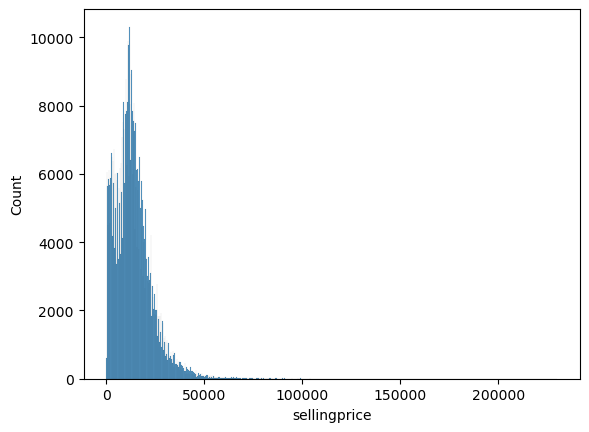

In [12]:
# sellingprices
sns.histplot(data=df, x='sellingprice')
df['sellingprice'].skew(), 

make
Rolls-Royce    153488.235294
Ferrari        127210.526316
Lamborghini    112625.000000
Bentley         74349.130435
airstream       71000.000000
                   ...      
dodge tk          550.000000
Geo               528.947368
dot               500.000000
ford truck        483.333333
Daewoo            450.000000
Name: sellingprice, Length: 94, dtype: float64

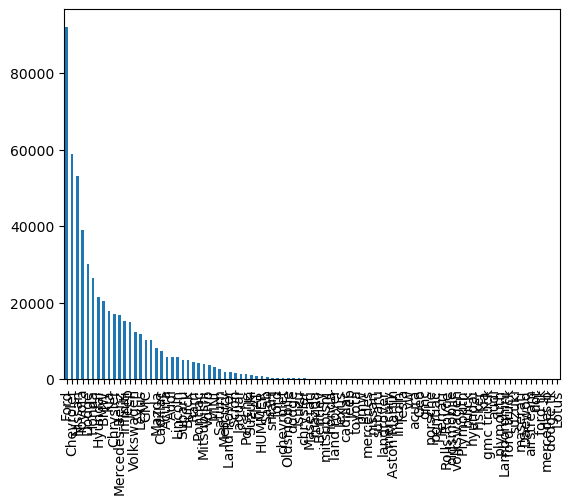

In [13]:
# make - sellingprice
df['make'].value_counts().plot(kind='bar')
df.groupby('make')['sellingprice'].mean().sort_values(ascending=False)

model
458 Italia        183000.000000
SLS AMG GT        156500.000000
i8                154222.222222
Flying Spur       154000.000000
Ghost             153488.235294
                      ...      
previa               308.333333
Spirit               300.000000
300e                 300.000000
Windstar Cargo       281.250000
Paseo                150.000000
Name: sellingprice, Length: 960, dtype: float64

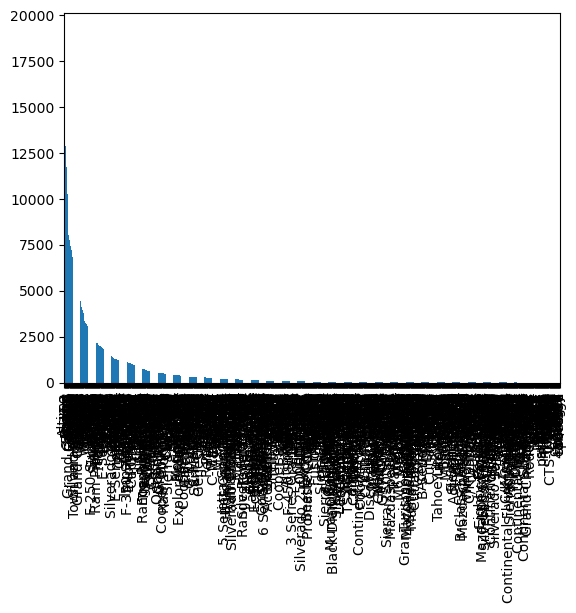

In [14]:
# model - sellingprice
df['model'].value_counts().plot(kind='bar')
df.groupby('model')['sellingprice'].mean().sort_values(ascending=False)

<AxesSubplot:ylabel='color'>

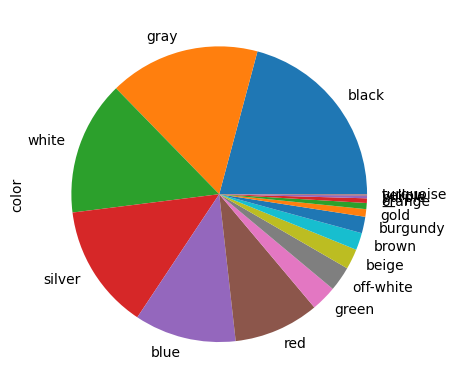

In [15]:
# color - state
# df['color'].value_counts().plot(kind='bar')

# ca_df = df.loc[df['state'] == 'ca']
# ca_df['color'].value_counts().plot(kind='pie')

ny_df = df.loc[df['state'] == 'ny']
ny_df['color'].value_counts().plot(kind='pie')

In [16]:
# color - sellingprice
df.groupby('color')['sellingprice'].mean().sort_values(ascending=False)

color
             24432.334869
—            17839.246526
charcoal     16440.427660
black        15653.189170
brown        15507.934476
off-white    15273.046788
white        14868.349666
gray         14082.469782
lime         13675.000000
orange       12919.316749
red          12844.658172
yellow       12823.642914
purple       12140.647444
burgundy     12085.618424
silver       11926.880330
pink         11823.170732
blue         11596.217820
beige         9631.114826
turquoise     8562.013216
green         8516.632603
gold          8493.704754
Name: sellingprice, dtype: float64

In [17]:
# state - sellingprice
df.groupby('state')['sellingprice'].mean().sort_values(ascending=False)

state
on    18717.674275
tn    17013.358778
pa    15992.830606
co    15916.296897
nv    15354.623995
il    15277.771237
mi    15039.378242
ca    14669.425948
mo    14558.442300
oh    14466.638717
wi    14189.333333
mn    14164.020799
wa    14044.501024
fl    14012.838824
nj    13710.607684
tx    13367.856909
qc    13285.570740
ne    13111.548190
ga    12977.671891
ny    12402.560680
ut    12262.332586
hi    12220.478508
az    11877.662544
or    11577.734375
ms    11244.130200
ab    11187.634989
la    10986.380267
in    10721.939736
sc    10471.657227
ns    10213.114754
pr     9472.567518
al     9142.307692
nc     8711.192910
va     8699.707248
ok     7782.500000
md     7458.833697
ma     6781.325165
nm     6291.812865
Name: sellingprice, dtype: float64

trim
EWB                  169000.000000
Autobiography LWB    135000.000000
Spider F1            117000.000000
S63 AMG 4MATIC       114333.333333
G63 AMG              112906.250000
                         ...      
fwd ext                 300.000000
Olympic Gold            300.000000
Estate                  300.000000
4x2 ext base            300.000000
sl                      275.000000
Name: sellingprice, Length: 1922, dtype: float64

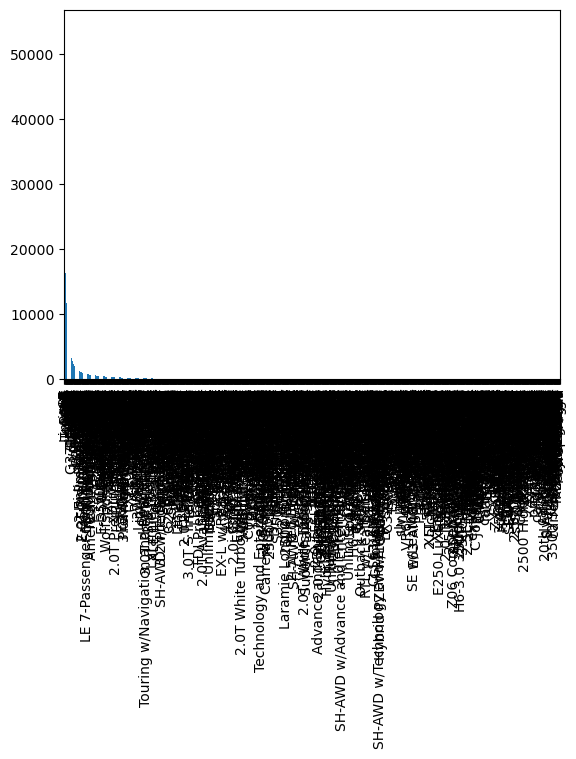

In [18]:
# trim - sellingprice
df['trim'].value_counts().plot(kind='bar')
df.groupby('trim')['sellingprice'].mean().sort_values(ascending=False)

In [19]:
# transmission - sellingprice
df.groupby('transmission')['sellingprice'].mean().sort_values(ascending=False)

transmission
             14997.254574
automatic    13683.459432
manual       11387.007334
Name: sellingprice, dtype: float64

In [20]:
# body - sellingprice
df.groupby('body')['sellingprice'].mean().sort_values(ascending=False)

body
granturismo convertible    79041.666667
GranTurismo Convertible    74000.000000
CTS-V Wagon                50500.000000
cts-v coupe                39707.142857
CTS-V Coupe                38024.851852
                               ...     
Xtracab                     5756.578947
xtracab                     5250.000000
Club Cab                    4782.587413
Cab Plus                    3266.666667
Ram Van                     1200.000000
Name: sellingprice, Length: 87, dtype: float64

In [21]:
# seller - sellingprice
df.groupby('seller')['sellingprice'].mean().sort_values(ascending=False), df['seller'].value_counts()

(seller
 phelps auto sales                           161000.000000
 financial services remarketing (bmw int)    153222.222222
 autolink sales llc                          134500.000000
 chings trading                              134000.000000
 carbiz solutions, inc.                      133000.000000
                                                 ...      
 sindibad auto sale llc                         200.000000
 beaverton honda                                200.000000
 american red cross/lehigh valley               200.000000
 republic finance llc/pearl                     200.000000
 titlemax/manning sc1                           150.000000
 Name: sellingprice, Length: 12962, dtype: float64,
 nissan-infiniti lt               19693
 ford motor credit company,llc    19159
 the hertz corporation            18296
 santander consumer               15282
 avis corporation                 12520
                                  ...  
 united motors sales                  1
 used cars 

In [22]:
# interior - sellingprice
df.groupby('interior')['sellingprice'].mean().sort_values(ascending=False)

interior
off-white    29103.678038
             24432.334869
red          23985.594796
brown        20412.065743
orange       19683.680556
burgundy     19664.136126
white        18909.421053
yellow       18226.315789
black        15722.120825
beige        13399.784814
purple       13306.909910
tan          12568.929980
—            12296.910342
gold         11449.845201
gray         11131.011386
silver       10772.125115
green        10147.406639
blue          8397.432432
Name: sellingprice, dtype: float64

In [23]:
# vin - sellingprice
df.groupby('vin')['sellingprice'].mean().sort_values(ascending=False)

vin
1fmcu9j98eua23833    230000.0
zff67nfa1b0178698    183000.0
wddug7kb2fa102347    173000.0
sca664s52dux52152    171500.0
sca664s58cux50727    169500.0
                       ...   
4a3aj56g1ve148491       100.0
2fahp71v99x109403       100.0
1fafp55222a271061       100.0
1ftne2ew6eda13643         1.0
4s2cm58v9s4375559         1.0
Name: sellingprice, Length: 538772, dtype: float64

<AxesSubplot:>

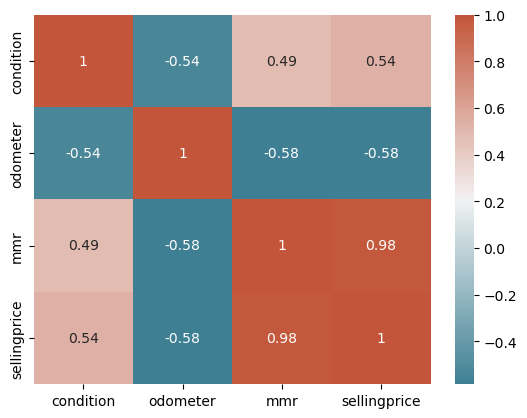

In [24]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:xlabel='saledate', ylabel='sellingprice'>

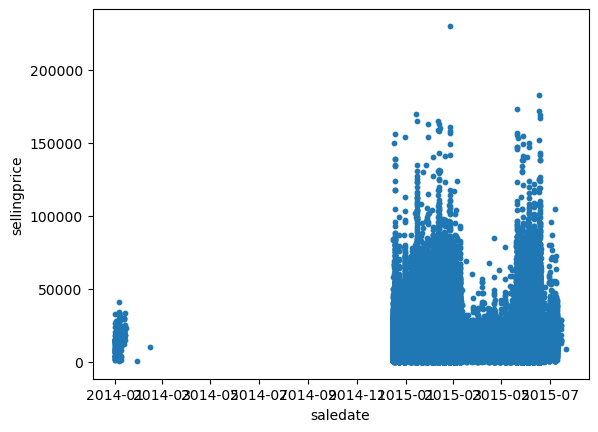

In [25]:
# salesdate - sellingprice
df.plot.scatter(x = 'saledate', y = 'sellingprice', s = 10)

<AxesSubplot:xlabel='year', ylabel='sellingprice'>

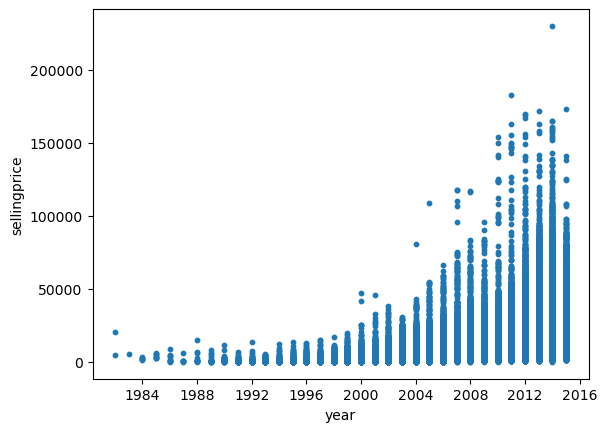

In [26]:
# year - sellingprice
df.plot.scatter(x = 'year', y = 'sellingprice', s = 10)

<AxesSubplot:xlabel='datediff', ylabel='sellingprice'>

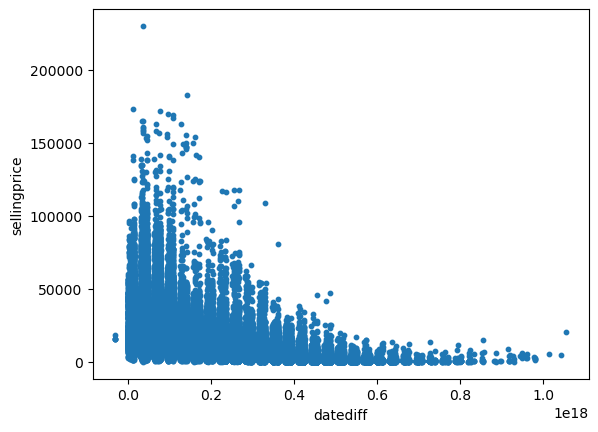

In [27]:
# diff year/saledate
df['datediff'] = df['saledate'] - df['year']
df.plot.scatter(x = 'datediff', y = 'sellingprice', s = 10)

In [28]:
# Models - Linear Regression, Random Forest Regression, KNN (K Nearest Neighbor) regression, XG Boost Regression, Decision Tree Regression, Multiple Linear Regression

In [29]:
def MSE(ypred, y):
    return sum([(a-b)**2 for a,b in zip(ypred,y)]) / len(y)

In [30]:
# features
# categorical: make, model, trim, body, transmission, state, color, interior, seller?
# numerical: condition, odometer, mmr
# temporal: year, saledate

In [31]:
# drop unused columns and shuffle
df = df.drop(['vin'], axis=1)
df = df.sample(frac=1).reset_index(drop=True)

In [32]:
# split train/test data
dfTrain = df.iloc[:500000,:]
dfTest = df.iloc[500000:,:]

In [33]:
### Linear Regression ###

In [34]:
sortedModels = sorted(df['model'].unique())
modelID = dict(zip(sortedModels, range(len(sortedModels))))
sortedBodies = sorted(df['body'].unique())
bodyID = dict(zip(sortedBodies, range(len(sortedBodies))))
sortedStates = sorted(df['state'].unique())
stateID = dict(zip(sortedStates, range(len(sortedStates))))
sortedColors = sorted(df['color'].unique())
colorID = dict(zip(sortedColors, range(len(sortedColors))))
sortedInteriors = sorted(df['interior'].unique())
interiorID = dict(zip(sortedInteriors, range(len(sortedInteriors))))

In [35]:
def feature(datum):
    body, model, state, color, interior, condition, odometer, mmr, datediff = datum
    feat1 = [0]*(len(bodyID)-1) # one hot encoding
    feat1[bodyID[body]-1] = 1 # one hot encoding
    feat2 = [0]*(len(modelID)-1)
    feat2[modelID[model]-1] = 1
    feat3 = [0]*(len(stateID)-1)
    feat3[stateID[state]-1] = 1
    feat4 = [0]*(len(colorID)-1)
    feat4[colorID[color]-1] = 1
    feat5 = [0]*(len(interiorID)-1)
    feat5[interiorID[interior]-1] = 1
    feat6 = [condition, odometer, mmr, datediff.days]
    return feat1 + feat2 + feat3 + feat4 + feat5 + feat6 + [1]

In [36]:
# select features
# make only: [75756191.19930969, 74967256.32282718, 75343504.49822089, 74384859.41072077, 75973162.44560608]
# model only: [51000071.02502295, 50608320.9638136 , 50974806.14551853, 50135419.47686031, 51345629.93953508]
# make and model: [50113386.57867035, 49499333.62023833, 50226943.59499285, 49403779.48839267, 50582326.38349926]
# make and model has slightly better outcome than model only
# so drop make feature to reduce complexity
# body only: [85240834.8856963 , 83734588.7010957 , 84969315.75263329, 83774595.12434384, 84853347.14931624]
# body and model: [49016055.63461547, 48496889.6764152 , 48928648.52571799, 48240619.75168139, 49320488.67982739]
# body and model has better outcome than model only
# so include body
# trim leads memory crush, so drop trim
# body/model/transmission: [48475405.51910668, 48959978.87864917, 48597231.04861394, 49214055.41808244, 48941331.18823658]
# almost no diff between body/model/transmission and body/model
# so drop transmission
# body/model/state: [46379019.9158247 , 46767386.24016201, 46495837.34710781, 47119459.46657164, 46744450.66590977]
# include state
# body/model/state/color: [45178849.77257725, 45535665.02123587, 45308374.65496247, 45926626.87470999, 45492529.76415594]
# include color
# body/model/state/color/interior: [43340783.29896469, 43604294.66221927, 43250176.51356039, 43921435.35528109, 43627520.22287305]
# include interior
# body/model/state/color/interior/condition: [30744054.83840411, 31945596.13104644, 31694879.13469771, 31278075.02279023, 31917692.97125573]
# include condition
# body/model/state/color/interior/condition/odometer: [19885278.56338654, 21242814.88427182, 20830015.66622217, 20460048.46159085, 21127241.54296536]
# include odometer
# body/model/state/color/interior/condition/odometer/mmr: [2342029.11688374, 2745888.60862158, 2441332.95751689, 2337699.87918977, 2340791.80532414]
# include mmr
# body/model/state/color/interior/condition/odometer/mmr/timediff: [2330241.3674382 , 2730324.55550871, 2424649.98867368, 2322346.76405202, 2321927.96615871]
# include timediff


In [37]:
# X = dfTrain.loc[:,dfTrain.columns!='sellingprice']
X = [feature(d) for d in dfTrain[['body','model','state','color','interior','condition','odometer','mmr','datediff']].values]
y = dfTrain['sellingprice'].values

In [38]:
# optimize lambda
# 0.5: [2804767.11678464 2302812.25755395 2289980.6756685  2420793.98240649 2342102.3218332 ]
# 1: [2804708.37233874 2301973.44773642 2289968.14967055 2420263.82757217 2341479.19156102]
# 2: [2804580.01934961 2301045.39249504 2290031.98658024 2419713.25491928 2340766.79203558]
# 3: [2804463.3024655  2300518.93461963 2290108.23421681 2419377.57232104 2340337.28442227]
# 4: [2804367.20562199 2300174.08367126 2290179.72385071 2419130.0807759 2340041.65210372]
# 5: [2804289.68668852 2299928.91266891 2290245.16834021 2418933.70185721 2339824.18222027]
# 6: [2679571.8140377  2361707.48559932 2373160.05587494 2316401.12107094 2432686.02437444]
# 7: [2679560.97527548 2361569.21833312 2373082.34192946 2316393.6606585 2432666.82753428]
# 8: [2679557.58926705 2361455.71802775 2373022.54989913 2316396.99574007 2432650.41621827]
# 9: [2679559.55475382 2361360.94963848 2372976.48998162 2316407.75612201 2432635.30498669]
# 10: [2679565.4652659  2361280.70429457 2372941.20564633 2316423.77379639 2432620.79294433]

# 8.0: [2379473.46853809 2898420.10244622 2299921.89694369 2290114.0461472 2338359.72746508]
# 8.2: [2379460.0756456  2898405.60726463 2299926.03614975 2290080.03543227 2338344.83072832]
# 8.4: [2379447.37197053 2898391.84528166 2299930.38873381 2290046.83383963 2338330.43258035]
# 8.6: [2379435.31727495 2898378.77981329 2299934.94023052 2290014.41213974 2338316.50933391]
# 8.8: [2379423.87433818 2898366.37644869 2299939.67725829 2289982.74260943 2338303.03890596]

# 8.8: [2284520.18759514 2322086.65975456 2414627.26837424 2753197.93516886 2401054.19034618]
# 8.9: [2284506.96478475 2322081.90827345 2414628.33560097 2753191.44105207 2401055.6170825 ]
# 9.0: [2284493.89088441 2322077.29769946 2414629.42812178 2753185.02693481 2401057.07456546]
# so pick 8.9


In [39]:
# lambdas = [8.8,8.9,9.0]

# for lamb in lambdas:
#     model = linear_model.Ridge(lamb, fit_intercept=False)
#     cv = KFold(n_splits=5)
#     scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
#                              cv=cv, n_jobs=-1, verbose=1)
#     print(-scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[2245951.1273536  2853745.79193844 2498707.47033507 2281329.9107807
 2264376.48138612]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min


[2245954.06214458 2853736.00118538 2498707.77529609 2281318.16052385
 2264372.27556388]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min


[2245957.00163547 2853726.40751161 2498708.11592691 2281306.59763144
 2264368.14427014]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


In [40]:
model = linear_model.Ridge(8.9, fit_intercept=False)
model.fit(X,y)

Ridge(alpha=8.9, fit_intercept=False)

In [41]:
testX = [feature(d) for d in dfTest[['body','model','state','color','interior','condition','odometer','mmr','datediff']].values]
testy = dfTest['sellingprice'].values
ypred = model.predict(testX)
MSE(ypred, testy)

2332500.8332198868

In [42]:
#TODO handle temporal data

In [43]:
### Random Forest regression ###

In [44]:
idf = pd.DataFrame()

In [45]:
categorical_cols = ['body', 'model', 'state', 'color', 'interior']
le = LabelEncoder()
idf[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

numerical_cols = ['condition', 'odometer', 'mmr', 'sellingprice']
idf[numerical_cols] = df[numerical_cols]

temporal_cols = ['datediff']
idf[temporal_cols] = df[temporal_cols]
idf['datediff'] = df['datediff'].apply(lambda x: x.days)

In [46]:
# split train/test data
idfTrain = idf.iloc[:500000,:]
idfTest = idf.iloc[500000:,:]

In [47]:
X = idfTrain.drop(['sellingprice'], axis=1)
y = idfTrain.loc[:, 'sellingprice']

In [ ]:
# optimize n_estimators
# 50: [2208075.96296411 2752946.78582882 2427311.28386109 2286637.42861378 2181954.79805138]
# 100: [2185986.48245167 2727952.9811777  2399046.86078087 2263039.36327851 2158540.14296748]
# 150: [2170933.12586105 2719324.70727055 2386771.39491197 2244683.33380537 2147138.99361301]
# 200: [2165141.50124216 2714380.16444292 2383389.87171589 2236991.75116596 2141210.85338553]
# 250: [2163866.08268517 2714291.66507237 2380067.64828118 2240853.32584104 2138760.25411476]
# 300: [2163898.42864367 2713609.34481203 2378039.59386866 2239060.81124815 2138096.36107022]
# 350: [2165593.56823318 2711817.07693313 2376935.10956467 2233726.21513059 2135564.14733052]
# so pick 250 (took one and half hours..)


In [52]:
# n_estimators = [50, 100, 150, 200, 250, 300, 350]

# # random_state=42?
# for est in n_estimators:
#     cv = KFold(n_splits=5)
#     score = cross_val_score(RandomForestRegressor(n_estimators=est, random_state=0), X, y, cv = cv, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
#     print(-score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[2208075.96296411 2752946.78582882 2427311.28386109 2286637.42861378
 2181954.79805138]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


[2185986.48245167 2727952.9811777  2399046.86078087 2263039.36327851
 2158540.14296748]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.3min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished


[2170933.12586105 2719324.70727055 2386771.39491197 2244683.33380537
 2147138.99361301]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.4min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


[2165141.50124216 2714380.16444292 2383389.87171589 2236991.75116596
 2141210.85338553]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.3min remaining: 15.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.3min finished


[2163866.08268517 2714291.66507237 2380067.64828118 2240853.32584104
 2138760.25411476]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.1min remaining: 18.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.1min finished


[2163898.42864367 2713609.34481203 2378039.59386866 2239060.81124815
 2138096.36107022]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 15.2min remaining: 22.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.2min finished


[2165593.56823318 2711817.07693313 2376935.10956467 2233726.21513059
 2135564.14733052]


In [54]:
model = RandomForestRegressor(n_estimators=250, random_state= 0)
model.fit(X, y)

RandomForestRegressor(n_estimators=250, random_state=0)

In [55]:
testX = idfTest.drop(['sellingprice'], axis=1)
testy = idfTest.loc[:, 'sellingprice']
ypred = model.predict(testX)
MSE(ypred, testy)

2248881.2531142547